# Transformée de Laplace inverse

## Introduction

La résolution d'équations différentielles linéaires peut s'effectuer en s'aidant de la transformée de Laplace. Via cette méthode, on accède dans un premier temps à la transformée de Laplace de la solution, qui se présente pour l'essentiel sous la forme d'une fraction rationnelle d'une variable complexe $p$.

Pour revenir à l'expression temporelle de la solution, il faut procéder à la **décomposition en éléments simples** de la fraction rationnelle en $p$, de sorte qu'apparaissent des termes élémentaires de la forme $\dfrac{K}{(p-a)^n}$ (dans le corps des complexes) pour lesquels l'expression temporelle associée $K\dfrac{t^{n-1}e^{at}\theta(t)}{(n-1)!}$ est connue.

L'idée ici est d'illustrer les méthodes de calcul via le package **sympy** de calcul symbolique. Mais il reste préférable de pouvoir **mener ces calculs avec un crayon et un papier**.

La validation s'effectuera avec la fonction **impulse_response** du package **control**.

## Les packages utiles

In [1]:
import sympy as sp
import numpy as np
import control as ct
from scipy.signal import lfilter
import matplotlib.pyplot as plt
from IPython.display import display

## Définition de $H(p)$ sous forme littérale

In [2]:
p, t, G = sp.symbols('p, t, G')
P = sp.IndexedBase('P')
Z = sp.IndexedBase('Z')
A = sp.IndexedBase('A')
Gn = [(G, 5)]
# Pn = [(P[0], -0.5), (P[1], -0.8), (P[2], -0.4)]
Pn = [(P[0], -0.5), (P[1], -0.8), (P[2], -0.7)]
OPn = [1, 3, 1]
Zn = [(Z[0], 0.1), (Z[1], 0.2)]
OZn = [1, 1]

In [3]:
H = Gn[0][0]
for k in range(len(Pn)):
    H = H/(1 - p/Pn[k][0])**OPn[k]
for k in range(len(Zn)):
    H = H*(1 - p/Zn[k][0])**OZn[k]
display(H)
display(H.subs(Pn).subs(Zn).subs(Gn))

G*(-p/Z[0] + 1)*(-p/Z[1] + 1)/((-p/P[0] + 1)*(-p/P[1] + 1)**3*(-p/P[2] + 1))

5*(1 - 10.0*p)*(1 - 5.0*p)/((1.25*p + 1)**3*(1.42857142857143*p + 1)*(2.0*p + 1))

## La fonction qui travaille sur l'expression littérale de $H(p)$

In [4]:
def inv_lapl(Gn, Zn, OZn, Pn, OPn, p, t):
    A = sp.IndexedBase('A')
    H = Gn[0][0]
    for k in range(len(Pn)):
        H = H/(1 - p/Pn[k][0])**OPn[k]
    for k in range(len(Zn)):
        H = H*(1 - p/Zn[k][0])**OZn[k]
    display(H)
    An = []
    h = 0
    tl = 0
    for k in range(len(Pn)):
        display(Pn[k][0])
        N = OPn[k]
        Fn = H
        R = (Fn*(p-Pn[k][0])**N).simplify()
        a = R.subs(p, Pn[k][0])
        h = h+A[k, N]*t**(N-1)*sp.exp(Pn[k][0]*t)/sp.factorial(N-1)
        tl = tl + A[k, N]/(p - Pn[k][0])**N
        print('degré', N, 'coeff', a.subs(Zn).subs(Pn).subs(Gn))
        An.append((A[k, N], a.subs(Zn).subs(Pn).subs(Gn)))
        for n in range(N, 1, -1):
            Fn = (Fn-a/(p-Pn[k][0])**n).expand()
            Fn = Fn.simplify()
            R = (Fn*(p-Pn[k][0])**(n-1)).simplify()
            a = R.subs(p, Pn[k][0])
            print('degré', n-1, 'coeff', a.subs(Zn).subs(Pn).subs(Gn))
            An.append((A[k, n-1], a.subs(Zn).subs(Pn).subs(Gn)))
            h = h+A[k, n-1]*t**(n-2)*sp.exp(Pn[k][0]*t)/sp.factorial(n-2)
            tl = tl + A[k, n-1]/(p - Pn[k][0])**(n-1)
    return An, h, tl

## Test de la fonction pour obtenir $h(t)$ sous forme littérale, puis numérique

In [5]:
An, h, tl = inv_lapl(Gn, Zn, OZn, Pn, OPn, p, t)
display(h)
display(h.subs(An).subs(Pn))
display(tl)
display(tl.subs(An).subs(Pn))

G*(-p/Z[0] + 1)*(-p/Z[1] + 1)/((-p/P[0] + 1)*(-p/P[1] + 1)**3*(-p/P[2] + 1))

P[0]

degré 1 coeff 3484.44444444444


P[1]

degré 3 coeff 1344.00000000000
degré 2 coeff 15082.6666666678
degré 1 coeff 157795.555557385


P[2]

degré 1 coeff -161280.000000000


t**2*exp(t*P[1])*A[1, 3]/2 + t*exp(t*P[1])*A[1, 2] + exp(t*P[0])*A[0, 1] + exp(t*P[1])*A[1, 1] + exp(t*P[2])*A[2, 1]

671.999999999999*t**2*exp(-0.8*t) + 15082.6666666678*t*exp(-0.8*t) + 157795.555557385*exp(-0.8*t) - 161280.0*exp(-0.7*t) + 3484.44444444444*exp(-0.5*t)

A[2, 1]/(p - P[2]) + A[1, 1]/(p - P[1]) + A[1, 2]/(p - P[1])**2 + A[1, 3]/(p - P[1])**3 + A[0, 1]/(p - P[0])

157795.555557385/(p + 0.8) + 15082.6666666678/(p + 0.8)**2 + 1344.0/(p + 0.8)**3 - 161280.0/(p + 0.7) + 3484.44444444444/(p + 0.5)

## Test de la méthode **apart** (ne fonctionne pas avec l'exemple)

In [6]:
display(H.subs(Zn).subs(Pn).subs(Gn).apart(p))

8.69902912621359*(1.0*p**2 - 0.3*p + 0.02)/(0.194174757281553*p**5 + 0.699029126213592*p**4 + 1.0*p**3 + 0.709902912621359*p**2 + 0.24978640776699*p + 0.0347961165048544)

## Test de la méthode **inverse_laplace_transform** (ne fonctionne pas avec l'exemple)

In [7]:
display(sp.inverse_laplace_transform(H.subs(Zn).subs(Pn).subs(Gn), p, t))

-2.60970873786408*(2.67678918532925*(-10.6877294364198 - 0.00250025882497242*I)*(-4.32698463356084 - 0.000231371366533037*I)*(0.999974711704035 + 1.46013208416434e-5*I)*(0.999999997467676 + 2.92070266710446e-5*I)*(1.06861691969783 + 2.04093920165301e-5*I)*(1.29803220317047 + 4.00643584959522e-5*I)*(17116.1105546082 - 9884.06929386775*I)*(-2.52999256296983e-5*exp(-0.799985395660794*t)*sin(2.52999256296983e-5*t) - 0.799985395660794*I*exp(-0.799985395660794*t)*sin(2.52999256296983e-5*t) - 0.799985395660794*exp(-0.799985395660794*t)*cos(2.52999256296983e-5*t) + 2.52999256296983e-5*I*exp(-0.799985395660794*t)*cos(2.52999256296983e-5*t))*gamma(5.05998512593967e-5*I) + 2.67678918532925*(-10.6877294364198 + 0.00250025882497242*I)*(-4.32698463356084 + 0.000231371366533037*I)*(0.999974711704035 - 1.46013208416434e-5*I)*(0.999999997467676 - 2.92070266710446e-5*I)*(1.06861691969783 - 2.04093920165301e-5*I)*(1.29803220317047 - 4.00643584959522e-5*I)*(17116.1105546082 + 9884.06929386775*I)*(-2.52999

## Utilisation du package **control**

In [8]:
p = ct.tf('s')
H = Gn[0][1]
for k in range(len(Pn)):
    H = H/(1 - p/Pn[k][1])**OPn[k]
for k in range(len(Zn)):
    H = H*(1 - p/Zn[k][1])**OZn[k]
H

TransferFunction(array([-0.896  ,  0.2688 , -0.01792]), array([-0.02    , -0.072   , -0.103   , -0.07312 , -0.025728, -0.003584]))

## Bilan avec comparaison

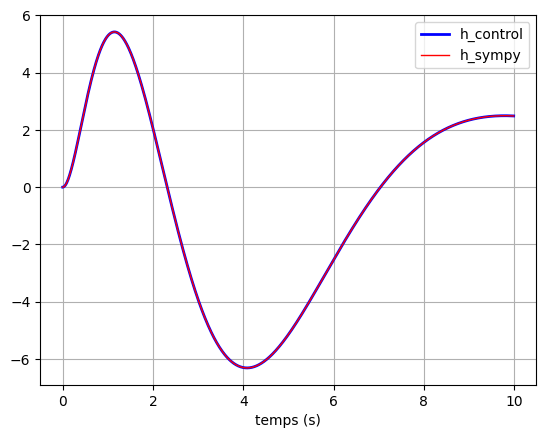

In [9]:
tps = np.arange(0, 10, 0.01)
rep = ct.impulse_response(H, tps)
h_control = rep.y[0][0]
h_sympy = np.real(sp.lambdify(t, h.subs(An).subs(Pn), 'numpy')(tps))
plt.plot(tps, h_control, 'b', lw=2, label='h_control')
plt.plot(tps, h_sympy, 'r', lw=1, label='h_sympy')
plt.grid('on')
plt.xlabel('temps (s)')
plt.legend()
plt.show()

## Méthodes de calcul

### Cas d'un pôle $p_0$ simple

$$F(p)=\dfrac{P(p)}{Q(p)}=\dfrac{P(p)}{B(p)(p-p_0)}=K(p)+\dfrac{a_1}{(p-p_0)}$$

$$a_1=\dfrac{P(p_0)}{B(p_0)}=F(p)(p-p_0)|_{p=p_0}$$

### Cas d'un pôle $p_0$ d'ordre de multiplicité N supérieur à 1

$$F(s)=\dfrac{P(p)}{Q(p)}=\dfrac{P(p)}{B(p)(p-p_0)^N}=K(s)+\Sigma_{n=1}^N\dfrac{a_n}{(p-p_0)^n}$$

$$a_N=\dfrac{P(p_0)}{B(p_0)}=F(p)(p-p_0)^N|_{p=p_0}$$

$$F_{N-1}(p)=F(p)-\dfrac{a_N}{(p-p_0)^N}=K(p)+\Sigma_{n=1}^{N-1}\dfrac{a_n}{(p-p_0)^n}$$

$$a_{N-1}=F_{N-1}(p)(p-p_0)^{N-1}|_{p=p_0}$$

Par récurrence :

$$F_N(p)=F(p)$$

$$a_N=F(p)(p-p_0)^N|_{p=p_0}$$

Pour $n$ variant de $N$ à $2$ :

$$F_{n-1}(p)=F_n(p)-\dfrac{a_n}{(p-p_0)^n}$$

$$a_{n-1}=F_{n-1}(p)(p-p_0)^{n-1}|_{p=p_0}$$
